In [19]:
from torchdiffeq import odeint
from torchdiffeq import odeint_adjoint as odeint_adj
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from random import sample
import time
import os
import copy

# Training neural ODE

In [29]:
class ODEFunc(nn.Module):
    def __init__(self, twice_dim):
        super(ODEFunc, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(twice_dim, 50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50, twice_dim),
            
        )
        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)
        
    def forward(self, t, y):
        
#         print(y.shape)
        out = self.net(y)
        #out = torch.ones(y.shape)
        #out[:,0] = y[:,2]
        #out[:,1] = y[:,3]
        #out[:,2] = y[:,0]/(0.6666**2)
        #out[:,3] = y[:,1]/(0.3333**2)
#         print(out.shape)
        return out


In [30]:
class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)


In [31]:
def GaussianXD(q, p):
    dim = q.shape[0]
    sigma = np.ones(dim)
    V = 0.5*np.sum(q**2 / (sigma**2))
    grad = q/(sigma**2)
    return V, grad

def Shell2D(q, p):
    r0 = np.sqrt(2)
    sigma = 0.5
    r = np.sqrt(np.dot(q, q))
    V = abs(r-r0)/sigma
    
    if (r-r0) == 0 or r == 0:
        grad = np.array([0, 0])
    else:
        grad = (q*(r-r0)/(sigma*r*abs(r-r0)))
        
    return V, grad

def Wofe_Quapp(q, p):
    x = q[0]
    y = q[1]
    V = x**4 + y**4 - 2*x**2 - 4*y**2 + x*y + 0.3*x + 0.1*y
    grad = np.array([4*x**3 - 4*x + y + 0.3, 4*y**3 - 8*y + x + 0.1])
    return V, grad

In [32]:
def get_batch_mod(traj,batch_size,batch_length,dt):
    
    twice_dim = traj.size()[2]
    sampled_is = torch.randint(traj.shape[0],size = (batch_size,))
    sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,))
    initial_time = sampled_js*dt
    
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
    pos_init = traj[sampled_is,sampled_js,:].view(-1, twice_dim)
    
    sampled_trajs = []
    
    for i in range(batch_size):          
        sampled_trajs.append(traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:].view(-1,twice_dim))
        
    batch_trajs = torch.stack(sampled_trajs,dim=1)
  
    return batch_t,pos_init,batch_trajs

In [33]:
# Wofe Quapp
training_trajs = torch.Tensor(np.load('wofe_quapp/trajs.npy'))
twice_dim = training_trajs.size()[2]
func = ODEFunc(twice_dim)

niters = 1000
optimizer = torch.optim.Adam(func.parameters(), lr=1e-2)
loss_meter = RunningAverageMeter()

nsample = 200
sampleLength = 10
dt = 0.1 

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, nsample, sampleLength,dt)

    pred_y = odeint_adj(func, batch_y0, batch_t)

    loss = torch.mean(torch.abs(pred_y - batch_y) )
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)
        
    if itr % 10 == 0: # do a validation step across entire trajectory
        for i in range(2):
            plt.plot(pred_y[:,i,1].detach().numpy(),pred_y[:,i,0].detach().numpy(),color='blue',alpha=0.5)
            plt.plot(batch_y[:,i,1].detach().numpy(),batch_y[:,i,0].detach().numpy(),color='red',alpha=0.5)
        plt.savefig('temp/{0}.png'.format(itr))
        plt.close()
        
# torch.save(func, 'wofe_quapp/model')    

KeyboardInterrupt: 

torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Si

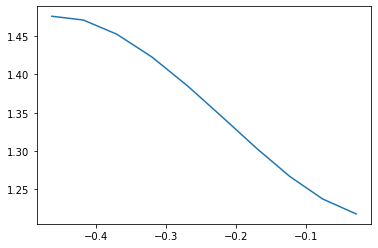

In [18]:
func = torch.load('2d_shell/model')
qs = [np.random.randn()*2 for i in range(twice_dim//2)]
ps = [np.random.randn()*0.7 for i in range(twice_dim//2)]
init = torch.tensor(qs+ps)
dt = 0.1
batch_length = 10
batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length)
pred_y = odeint_adj(func, init, batch_t)
plt.plot(pred_y[:, 0].detach().numpy(),pred_y[:, 1].detach().numpy())
plt.show()

# HMC with Neural ODE

In [78]:
class ODEFunc_exact_den(nn.Module):
    def __init__(self,ODE_model):
        super(ODEFunc_exact_den, self).__init__()
        self.net = ODE_model
        
    def forward(self, t, y):
#         start = time.time()
        #print("here")
        zero = torch.tensor([0.0]).view(-1,1)
#         print('zero', zero.shape)
#         print('y',y.shape)
        inp = torch.cat((zero,y[:,:-1]),dim=1)
#         print(inp)
        f = self.net(t,y[:,:-1])
        #print(time.time()-start)
        Jacobian = torch.autograd.functional.jacobian(self.net, (t,y[:,:-1]))
        #print(time.time()-start)
        
        Tr = torch.trace(Jacobian[1].view(twice_dim,twice_dim)).view(-1,1)
        
        out = torch.cat((f,-Tr),dim=1)
        return out

In [79]:
def Evaluate_H(f, q,p,M_inv):
    V_o,grad = f(q,p)
    H_o = V_o + 0.5*( np.matmul(p.reshape(1,-1),np.matmul(M_inv,p.reshape(-1,1)))   )
    H_o = H_o.reshape(-1)
    return H_o

In [90]:
def Neural_dynamics(f,q_temp,p_temp,M,M_inv,steps,eps,store=True):
    dim = q_temp.shape[0]
    
    batch_t = torch.linspace(0.0,eps*(steps-1),steps)
    #print(batch_t.shape)
    
    q_temp = torch.tensor(q_temp)
    p_temp = torch.tensor(p_temp)
    Zero = torch.tensor([0.0])
    init = torch.cat((q_temp,p_temp,Zero),dim=0).float()
    init = init.view(1,-1)
#     print(init.shape)
    start = time.perf_counter()
    pred_y = odeint(func_mod, init, batch_t,method = 'rk4',options = dict(step_size=eps))
    print(time.perf_counter()-start)
    #print(pred_y.shape)
    
    
    pred_y = pred_y.detach().numpy()
    p_y = pred_y[:,0,:-1]
    J = pred_y[:,0,-1]
    
    energies = []
    
    for i in range(p_y.shape[0]):
        q = p_y[i,:dim]
        p = p_y[i,dim:]
        curr_e = Evaluate_H(f,q,p,M_inv)
    
        energies.append(curr_e)
    
    energies = np.asarray(energies)
    #print(energies.shape)
    #print(p_y.shape)
    return (p_y[-1,:dim],p_y[-1,dim:]),J[-1],p_y,energies



In [91]:
def Neural_HMC(f,q0,num_samples,eps,steps,store=False):
    
    samples = []
    accept_rate = 0
    q = q0
    
    if store == True:
        stored_vals = np.zeros((num_samples,steps,twice_dim))
        energies = np.zeros((num_samples,steps))
        
    ind = 0
    M = np.identity(twice_dim//2)
    M_inv = np.linalg.inv(M)
    while len(samples) < num_samples:
        
        ####### Need to fix
        mean = np.zeros((twice_dim//2))
        cov = M
        p = np.random.multivariate_normal(mean, cov)
        
        q_temp = copy.deepcopy(q)
        p_temp = copy.deepcopy(p)
        
        (q_f,p_f),J,path,energy = Neural_dynamics(f,q_temp,p_temp,M,M_inv,steps,eps,store=True)
        stored_vals[ind,:,:] = np.asarray(path)
        energies[ind,:] = np.asarray(energy).reshape(-1)
        
        p_f *= -1
        
        
        V_o,grad = f(q,p)
        V_f,grad = f(q_f,p_f)
        H_o = V_o + 0.5*np.matmul(p.reshape(1,-1),np.matmul(M_inv,p.reshape(-1,1)))
        H_o = H_o.reshape(-1)
        H_f = V_f + 0.5*np.matmul(p_f.reshape(1,-1),np.matmul(M_inv,p_f.reshape(-1,1)))
        H_f = H_f.reshape(-1)
        
        acceptance = (H_o - H_f) + J
        
        val = np.log(np.random.rand())
        #print(J.shape)
        #print(acceptance.shape)
        
        if val < acceptance:
            q = q_f
            accept_rate += 1
        
        samples.append(q)
        
        if len(samples)%500 == 0 and len(samples)< 2000:
            if len(samples) == 500:
                recent_samples = np.asarray(samples)
            else:
                recent_samples = np.asarray(samples[-500:])
            if (np.abs(np.linalg.det(np.cov(recent_samples.T))) > 0.001):
                M_inv = np.cov(recent_samples.T)
                M = np.linalg.inv(M_inv)
            else:
                M = np.identity(twice_dim//2)
                M_inv = np.linalg.inv(M)
#             print(M_inv)
        ind+=1
             
    acceptance = accept_rate/num_samples
#     print(stored_vals.shape)
#     print(energies.shape)
    return samples,stored_vals,energies, acceptance

In [92]:
# Wofe-Quapp
num_samples = [100]#[10000] #[100, 200, 500, 1000, 2000]
twice_dim = 4
init = np.random.randn(twice_dim//2)*2
traj_length = 50
traj_step_size = 0.1
num_of_runs = 5
potential = 'wofe_quapp'
potential_function = Wofe_Quapp
func = torch.load(f'{potential}/model')
func_mod = ODEFunc_exact_den(func)

start = time.perf_counter()
for q in num_samples:
    for i in range(1, num_of_runs+1):
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)
#         if not os.path.exists(f'{potential}/neural_{q}'):
#             os.makedirs(f'{potential}/neural_{q}')

#         with open(f'{potential}/neural_{q}/{i}_hmc_samps.npy', 'wb') as f:
#             np.save(f, samps)

#         with open(f'{potential}/neural_{q}/{i}_info.npy', 'wb') as f:
#             np.save(f, np.array([time.perf_counter() - start, acceptance]))
        print(q, i)
print(time.perf_counter() - start)


0.12526560109108686
0.12313965987414122
0.12325534923002124
0.12301078089512885
0.123272375902161
0.12268958007916808
0.12585422699339688
0.12579586915671825
0.12463830993510783
0.12592837819829583
0.12540996610186994
0.12236729194410145
0.12290345318615437
0.12273916299454868
0.12300442601554096
0.1232741370331496
0.12334194383583963
0.12302190694026649
0.12315263785421848
0.12284508091397583
0.1232045260258019
0.12270601885393262
0.12320044497027993
0.12304295995272696
0.12316275108605623
0.12296056607738137
0.1231114468537271
0.12294169492088258
0.12317225011065602
0.12287343898788095
0.12306508398614824
0.12273865099996328
0.12300667096860707
0.1226921018678695
0.12506169988773763
0.17239110404625535
0.11836371198296547
0.11711357487365603
0.11747609893791378
0.11726626683957875
0.11734262481331825
0.11679118918254972
0.11730960407294333
0.11681095603853464
0.11705280491150916
0.11684905318543315
0.1171319920103997
0.11708712088875473
0.11727600498124957
0.11690811906009912
0.11795

0.11792129604145885
0.11819076398387551
0.1179813239723444
0.11783470399677753
0.1185903549194336
0.1178729438688606
0.11805210285820067
0.11778539814986289
0.11784394807182252
0.11770803993567824
0.11794277606531978
0.11755163897760212
0.1180789889767766
0.1177451650146395
0.11784058483317494
0.11787595110945404
0.11799003300257027
0.11777928797528148
0.11794365383684635
0.11776681593619287
0.11793166003189981
0.1177504351362586
0.11785899614915252
0.11772775906138122
0.11803224380128086
0.11861638003028929
0.1338058360852301
0.13359368895180523
0.13387061189860106
0.13336888002231717
0.1337541388347745
0.1476215859875083
0.1393699620384723
0.13341027707792819
0.13388644205406308
0.13356177089735866
0.13373932498507202
0.133484975900501
0.1337915000040084
0.12070732819847763
0.11809192108921707
0.11793583096005023
0.1180905089713633
0.1176407269667834
0.11809810996055603
0.11779496213421226
0.11780621204525232
0.11773173790425062
0.1178085261490196
0.11769202002324164
0.11794325592927

In [93]:
# Shell 2D
num_samples = [100] #[100, 200, 500, 1000, 2000]
twice_dim = 4
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.01
num_of_runs = 20
potential = '2d_shell'
potential_function = Shell2D
func = torch.load(f'{potential}/model')
func_mod = ODEFunc_exact_den(func)

start = time.perf_counter()        
for q in num_samples:
    for i in range(1, num_of_runs+1):
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

#         if not os.path.exists(f'{potential}/neural_{q}'):
#             os.makedirs(f'{potential}/neural_{q}')

#         with open(f'{potential}/neural_{q}/{i}_hmc_samps.npy', 'wb') as f:
#             np.save(f, samps)

#         with open(f'{potential}/neural_{q}/{i}_info.npy', 'wb') as f:
#             np.save(f, np.array([time.perf_counter() - start, acceptance]))
#         print(q, i)
print(time.perf_counter() - start)


0.02663175412453711
0.025933255907148123
0.02590642007999122
0.025735458126291633
0.02570769004523754
0.025539154885336757
0.025528655154630542
0.025447018910199404
0.02525609196163714
0.025536427041515708
0.04388742009177804
0.04853394185192883
0.0487692030146718
0.04875711095519364
0.04871633090078831
0.025638798950240016
0.025569788878783584
0.02552951592952013
0.025578740052878857
0.025522694922983646
0.02586206584237516
0.02556145517155528
0.02552804001607001
0.025540111120790243
0.02552183298394084
0.025450980057939887
0.025523700984194875
0.02551606297492981
0.02579379896633327
0.02547114691697061
0.02552872896194458
0.025502959033474326
0.025570247089490294
0.02561549306847155
0.025544589152559638
0.025559185072779655
0.025827277917414904
0.02554623782634735
0.025537763023748994
0.025506204925477505
0.025560795096680522
0.025539816124364734
0.025506882928311825
0.025533751817420125
0.02586555597372353
0.02549196081236005
0.02554635307751596
0.025513854110613465
0.02557930396869

0.02580784587189555
0.025495446985587478
0.025516226887702942
0.025519188027828932
0.02557788509875536
0.02550031105056405
0.025480580981820822
0.025603678077459335
0.025931284064427018
0.025549670914188027
0.025542321847751737
0.02554355002939701
0.02555293613113463
0.025536941131576896
0.025564586045220494
0.025590162025764585
0.025887528900057077
0.025574947940185666
0.025491873966529965
0.02554924786090851
0.025552073027938604
0.025515676010400057
0.025608599884435534
0.025496691931039095
0.025803142925724387
0.025480807991698384
0.02554035116918385
0.025495920795947313
0.02559947711415589
0.02556603797711432
0.025525072123855352
0.025529479142278433
0.025855398969724774
0.02548466296866536
0.0255084119271487
0.025522310053929687
0.025537445908412337
0.02547762799076736
0.025503565790131688
0.02554540801793337
0.02583305793814361
0.025471266824752092
0.025528546888381243
0.02554445108398795
0.025530786952003837
0.02562378183938563
0.02576540899462998
0.0255910640116781
0.0259407830

0.025839917128905654
0.025545526994392276
0.025578150991350412
0.02560305898077786
0.025544409872964025
0.025559778092429042
0.02561454800888896
0.025569865945726633
0.02586249401792884
0.025538509944453835
0.025537363020703197
0.025657644029706717
0.025608332129195333
0.025628444040194154
0.025515907909721136
0.025503437034785748
0.025773734087124467
0.025560008827596903
0.02555709588341415
0.02562382398173213
0.02547098882496357
0.0255639951210469
0.02551803016103804
0.02561426186002791
0.025900312000885606
0.025483798934146762
0.025511682964861393
0.025476991897448897
0.025498102884739637
0.02552383905276656
0.025590826058760285
0.025512900901958346
0.02577764797024429
0.02561287395656109
0.025576840853318572
0.025521264178678393
0.025603858986869454
0.025546940974891186
0.02552804397419095
0.025523368967697024
0.025772440945729613
0.025539825204759836
0.025832146871834993
0.02554186014458537
0.025518304901197553
0.025510734878480434
0.025539888069033623
0.025563423056155443
0.02579

0.025840235175564885
0.02566757006570697
0.025480816839262843
0.025509702041745186
0.025547228986397386
0.025524099823087454
0.025504854042083025
0.025566315045580268
0.025960723869502544
0.02560955611988902
0.025481659919023514
0.025516831083223224
0.025466039078310132
0.025529128033667803
0.025424971943721175
0.025475909002125263
0.025782108074054122
0.025493680965155363
0.025462619960308075
0.025444598868489265
0.025477417977526784
0.02547144005075097
0.025409796042367816
0.025555690051987767
0.025902464985847473
0.02560828998684883
0.025490960106253624
0.025506868958473206
0.025496081914752722
0.025436467956751585
0.025532724102959037
0.025441386038437486
0.025793121894821525
0.025660524843260646
0.025460134958848357
0.02548612211830914
0.025477810064330697
0.025508856866508722
0.025555489817634225
0.025464925915002823
0.025880313012748957
0.025644231820479035
0.0254945729393512
0.025469314074143767
0.02548944903537631
0.025550169171765447
0.025462611112743616
0.025545286014676094


0.025805603014305234
0.025485931895673275
0.025526064913719893
0.02557901805266738
0.0255898789037019
0.02560848300345242
0.02552974713034928
0.025541245006024837
0.025830192025750875
0.025489465100690722
0.025565637974068522
0.025536288041621447
0.025495567824691534
0.025505024939775467
0.025500936899334192
0.025586588075384498
0.025859646033495665
0.02550764987245202
0.025483171921223402
0.025557447923347354
0.025470318971201777
0.025547978933900595
0.02551734517328441
0.02550777606666088
0.025824252981692553
0.02561183786019683
0.02547611203044653
0.025565461022779346
0.026715954998508096
0.02559312805533409
0.025484432000666857
0.02549435803666711
0.02580952807329595
0.025475610978901386
0.02567400294356048
0.02549500297755003
0.02551609603688121
0.025715814903378487
0.025590881006792188
0.025653421878814697
0.02577395411208272
0.025483357021585107
0.025631294818595052
0.025568574899807572
0.025498441886156797
0.025470247957855463
0.025433937087655067
0.025473210029304028
0.0259257

In [ ]:
# Gaussian 10D
num_samples = [10000]#[100, 200, 500, 1000, 2000]
twice_dim = 20
init = np.random.randn(twice_dim//2)*2
traj_length = 10
traj_step_size = 0.1
num_of_runs = 5
potential = '10d_gaussian'
potential_function = GaussianXD
func = torch.load(f'{potential}/model')
func_mod = ODEFunc_exact_den(func)

for q in num_samples:
    for i in range(1, num_of_runs+1):
        start = time.perf_counter()
        samps,trajs,energies,acceptance = Neural_HMC(potential_function, init, q, traj_step_size, traj_length, store=True)

        if not os.path.exists(f'{potential}/neural_{q}'):
            os.makedirs(f'{potential}/neural_{q}')

        with open(f'{potential}/neural_{q}/{i}_hmc_samps.npy', 'wb') as f:
            np.save(f, samps)

        with open(f'{potential}/neural_{q}/{i}_info.npy', 'wb') as f:
            np.save(f, np.array([time.perf_counter() - start, acceptance]))
        print(q, i)
